# StreamRHF Implementation:
### Authors:
#### Cristian Alejandro CHÁVEZ BECERRA
#### Giovanni BENEDETTI DA ROSA

### Comparison on a random dataset

In this section we will generate a toy dataset to test the model and evaluate that the implementation and integration with CapyMOA is properly working

#### Generating the dataset

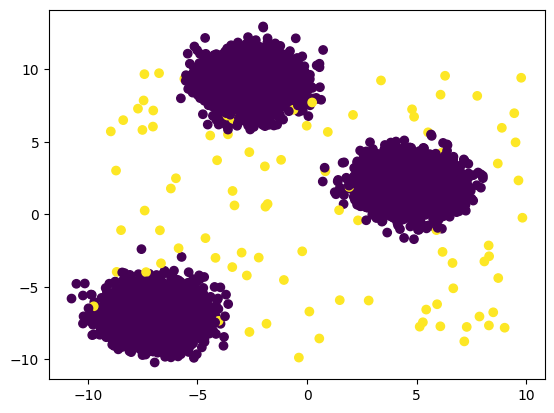

In [4]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from capymoa.stream import NumpyStream

# generate normal data points
n_samples = 10000
n_features = 2
n_clusters = 3
X, y = make_blobs(
    n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42
)

# generate anomalous data points
n_anomalies = 100  # the anomaly rate is 1%
anomalies = np.random.uniform(low=-10, high=10, size=(n_anomalies, n_features))

# combine the normal data points with anomalies
X = np.vstack([X, anomalies])
y = np.hstack([y, [1] * n_anomalies])  # Label anomalies with 1
y[:n_samples] = 0  # Label normal points with 0

# shuffle the data
idx = np.random.permutation(n_samples + n_anomalies)
X = X[idx]
y = y[idx]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

# create a NumpyStream from the combined dataset
feature_names = [f"feature_{i}" for i in range(n_features)]
target_name = "class"

#### Evaluating StreamRHF on the dataset

In [11]:
from capymoa.anomaly import HalfSpaceTrees, StreamRHF
from capymoa.evaluation import AnomalyDetectionEvaluator
from capymoa.stream import NumpyStream

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
learner = StreamRHF(stream_ad.get_schema())
evaluator = AnomalyDetectionEvaluator(stream_ad.get_schema())
while stream_ad.has_more_instances():
    instance = stream_ad.next_instance()
    score = learner.score_instance(instance)
    evaluator.update(instance.y_index, score)
    learner.train(instance)

auc = evaluator.auc()
print(f"AUC: {auc:.2f}")

our StreamRHF initialized
20
AUC: 0.77


We can appreciate that the implementation and integration succeed since we called the class "StreamRHF" the same way as the other classes of Anomaly Detection. Furthermore, we could see that the evaluator has a good score for the AUC of 0.77

#### Comparison with the models

Now, once we know we could integrate the class with CapyMOA and properly run it as the other classes we will do a comparison of the AUC score with the other 4 models of CapyMOA tailoredfor Anomaly Detection. We will evaluate them in the following order:

-HalfSpaceTrees

-Autoencoder

-OnlineIsolationForest

-StreamRHF

##### HalfSpaceTrees

AUC: 0.945231


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.940199,0.216290,0.064,0.001332,0.000000,0.012146,0.229416,1.0,-77.000000
1,2000.0,0.924924,0.174265,0.016,0.000000,0.940199,0.016260,0.000000,1.0,-69.285714
2,3000.0,0.961442,0.215525,0.008,0.000000,0.924924,0.008065,0.000000,1.0,-81.666667
3,4000.0,0.922169,0.181030,0.007,0.000000,0.961442,0.007049,0.000000,1.0,-91.372093
4,5000.0,0.963000,0.201041,0.009,0.000000,0.922169,0.009082,0.000000,1.0,-94.288462
5,6000.0,0.962435,0.225071,0.013,0.000000,0.963000,0.013171,0.000000,1.0,-90.107692
6,7000.0,0.950853,0.218543,0.003,0.000000,0.962435,0.003009,0.000000,1.0,-101.632353
7,8000.0,0.941127,0.197094,0.012,0.000000,0.950853,0.012146,0.000000,1.0,-97.800000
8,9000.0,0.964214,0.189741,0.008,0.000000,0.941127,0.008065,0.000000,1.0,-100.454545
9,10000.0,0.946272,0.199078,0.012,0.000000,0.964214,0.012146,0.000000,1.0,-97.800000


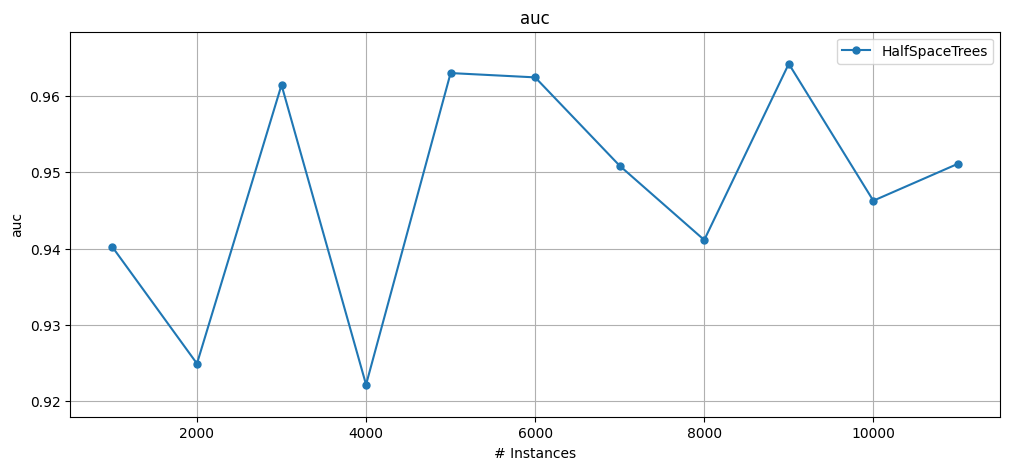

In [6]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.anomaly import HalfSpaceTrees, Autoencoder,OnlineIsolationForest, StreamRHF
from capymoa.evaluation import prequential_evaluation_anomaly

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
hst = HalfSpaceTrees(schema=stream_ad.get_schema())

results_hst = prequential_evaluation_anomaly(
    stream=stream_ad, learner=hst, window_size=1000
)

print(f"AUC: {results_hst.auc()}")
display(results_hst.windowed.metrics_per_window())
plot_windowed_results(results_hst, metric="auc", save_only=False)

##### Autoencoder

AUC: 0.4901885


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.415612,-0.125707,0.012,0.000000,0.000000,0.012146,0.000000,1.000,-81.333333
1,2000.0,0.545636,-0.150891,0.017,0.000033,0.415612,0.016260,0.031879,1.000,-69.214286
2,3000.0,0.377898,-0.066564,0.009,0.000016,0.545636,0.008065,0.031750,1.000,-81.583333
3,4000.0,0.570278,-0.149823,0.009,0.000028,0.377898,0.007049,0.044879,1.000,-91.186047
4,5000.0,0.641103,-0.217670,0.009,0.000000,0.570278,0.009082,0.000000,1.000,-94.288462
5,6000.0,0.457252,-0.125842,0.013,0.000000,0.641103,0.013171,0.000000,1.000,-90.107692
6,7000.0,0.586760,-0.184939,0.003,0.000000,0.457252,0.003009,0.000000,1.000,-101.632353
7,8000.0,0.515604,-0.187584,0.012,0.000000,0.586760,0.012146,0.000000,1.000,-97.800000
8,9000.0,0.449786,-0.095496,0.007,-0.002002,0.515604,0.008065,0.000000,0.875,-100.556818
9,10000.0,0.416835,-0.081609,0.013,0.000024,0.449786,0.012146,0.031814,1.000,-97.700000


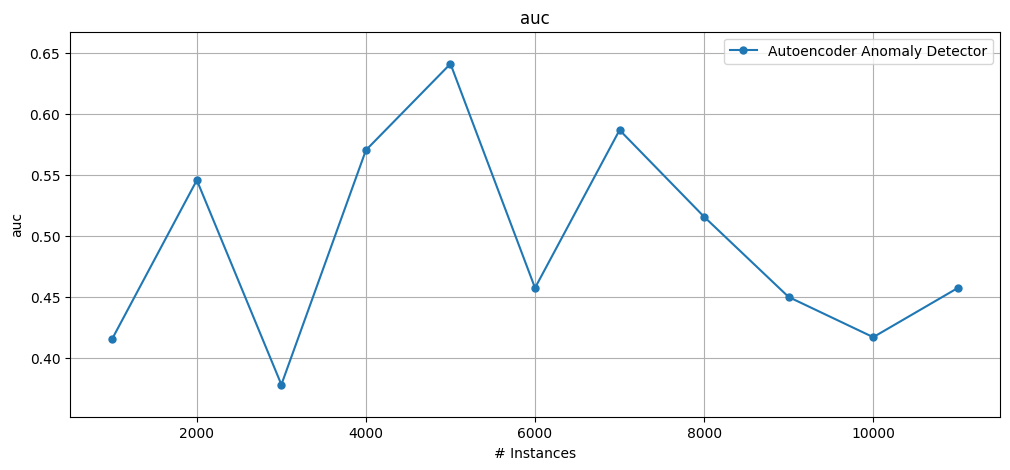

In [7]:
ae = Autoencoder(schema=stream_ad.get_schema(), hidden_layer=1)

results_ae = prequential_evaluation_anomaly(
    stream=stream_ad, learner=ae, window_size=1000
)

print(f"AUC: {results_ae.auc()}")
display(results_ae.windowed.metrics_per_window())
plot_windowed_results(results_ae, metric="auc", save_only=False)

##### OnlineIsolationForest

AUC: 0.377265


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.497723,0.054403,0.045,0.000829,0.000000,0.012146,0.182759,1.000000,-78.583333
1,2000.0,0.288173,0.008291,0.016,0.000000,0.497723,0.016260,0.000000,1.000000,-69.285714
2,3000.0,0.472782,0.018121,0.008,0.000000,0.288173,0.008065,0.000000,1.000000,-81.666667
3,4000.0,0.381384,0.011910,0.007,0.000000,0.472782,0.007049,0.000000,1.000000,-91.372093
4,5000.0,0.156968,0.004139,0.006,-0.006018,0.381384,0.009082,0.000000,0.666667,-94.576923
5,6000.0,0.500000,0.016570,0.013,0.000000,0.156968,0.013171,0.000000,1.000000,-90.107692
6,7000.0,0.674356,0.021449,0.003,0.000000,0.500000,0.003009,0.000000,1.000000,-101.632353
7,8000.0,0.342696,0.008663,0.011,-0.002002,0.674356,0.012146,0.000000,0.916667,-97.900000
8,9000.0,0.265247,0.006713,0.006,-0.004008,0.342696,0.008065,0.000000,0.750000,-100.659091
9,10000.0,0.474907,0.014726,0.012,0.000000,0.265247,0.012146,0.000000,1.000000,-97.800000


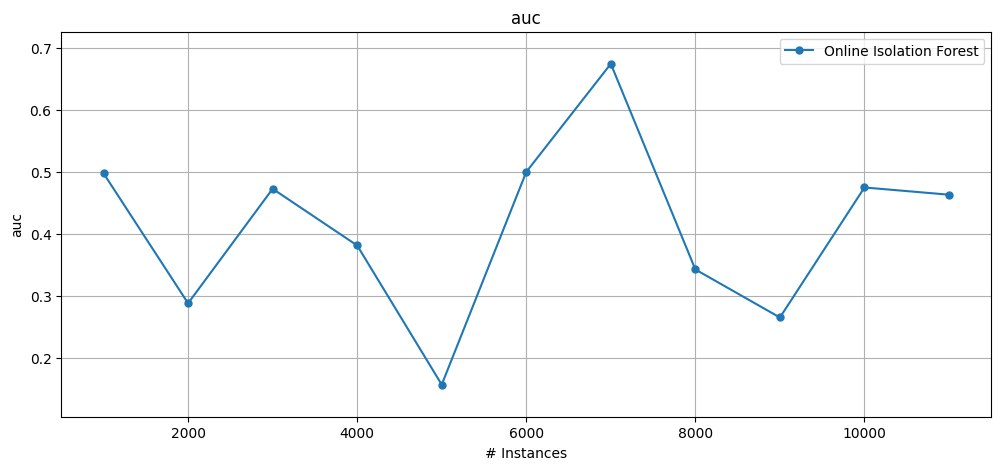

In [8]:
oif = OnlineIsolationForest(schema=stream_ad.get_schema(), num_trees=10)

results_oif = prequential_evaluation_anomaly(
    stream=stream_ad, learner=oif, window_size=1000
)

print(f"AUC: {results_oif.auc()}")
display(results_oif.windowed.metrics_per_window())
plot_windowed_results(results_oif, metric="auc", save_only=False)

##### StreamRHF

our StreamRHF initialized
20
AUC: 0.685068


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.670125,0.107888,0.023,0.000270,0.000000,0.012146,0.105516,1.0,-80.416667
1,2000.0,0.715066,0.122539,0.040,0.000799,0.670125,0.016260,0.156174,1.0,-67.571429
2,3000.0,0.675466,0.103466,0.020,0.000196,0.715066,0.008065,0.109985,1.0,-80.666667
3,4000.0,0.758884,0.116801,0.015,0.000114,0.675466,0.007049,0.089757,1.0,-90.627907
4,5000.0,0.772676,0.123267,0.021,0.000221,0.758884,0.009082,0.110041,1.0,-93.134615
5,6000.0,0.772309,0.121042,0.030,0.000455,0.772676,0.013171,0.131240,1.0,-88.538462
6,7000.0,0.654965,0.087852,0.014,0.000067,0.772309,0.003009,0.105039,1.0,-100.500000
7,8000.0,0.655828,0.106100,0.034,0.000546,0.654965,0.012146,0.149222,1.0,-95.600000
8,9000.0,0.657447,0.101880,0.024,0.000262,0.655828,0.008065,0.127000,1.0,-98.818182
9,10000.0,0.539895,0.071883,0.020,0.000196,0.657447,0.012146,0.089984,1.0,-97.000000


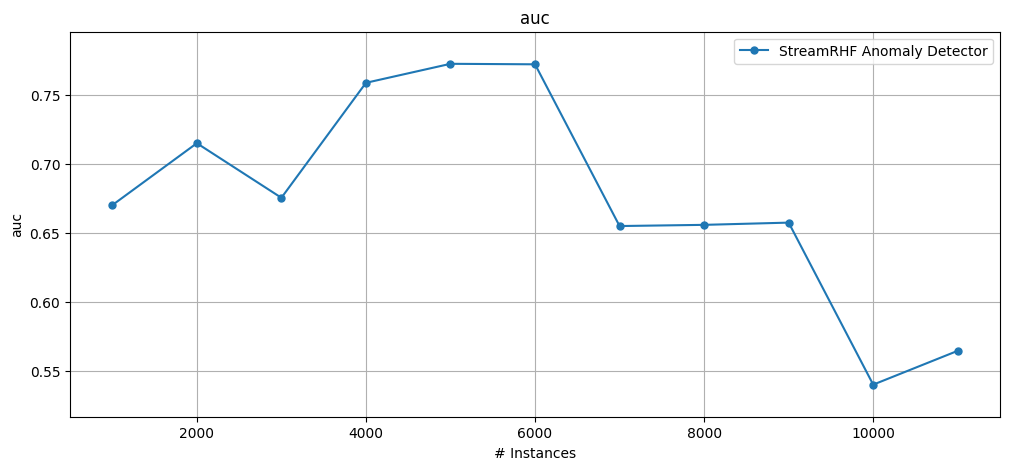

In [9]:
streamrhf = StreamRHF(schema=stream_ad.get_schema(), num_trees=10)

results_streamrhf = prequential_evaluation_anomaly(
    stream=stream_ad, learner=streamrhf, window_size=1000
)

print(f"AUC: {results_streamrhf.auc()}")
display(results_streamrhf.windowed.metrics_per_window())
plot_windowed_results(results_streamrhf, metric="auc", save_only=False)

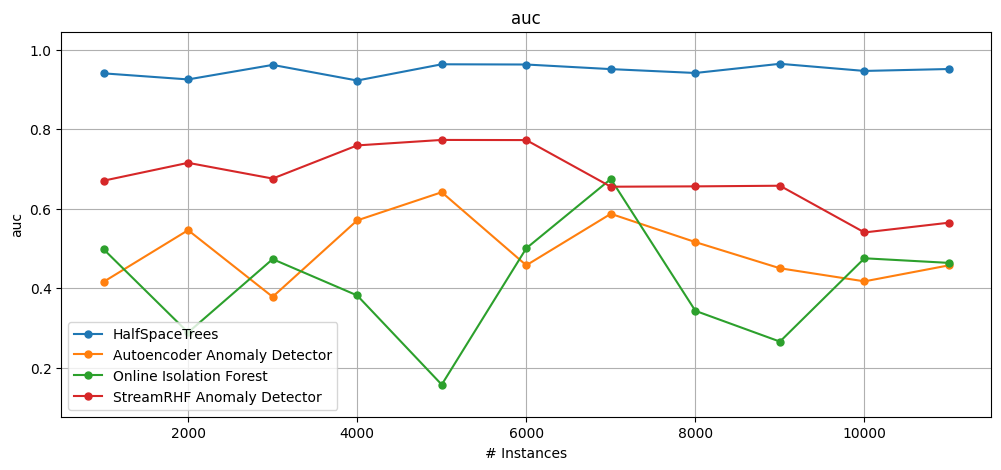

In [10]:
plot_windowed_results(
    results_hst, results_ae, results_oif, results_streamrhf, metric="auc", save_only=False
)

### Comparison on a Capymoa dataset

our StreamRHF initialized
20
HalfSpaceTrees AUC: 0.5358045479630744


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,100.0,0.360963,-5.469677e-02,0.38,-0.256078,0.000000,0.515152,0.353238,0.294118,-1.000000
1,200.0,1.000000,9.095907e-02,0.65,0.000000,0.360963,1.857143,0.000000,1.000000,0.239130
2,300.0,0.000000,6.852733e-17,0.78,-0.019462,1.000000,0.265823,0.000000,0.000000,0.503759
3,400.0,0.999576,1.285029e-01,0.44,0.075297,0.000000,1.631579,0.311086,0.096774,-0.114428
4,500.0,0.021277,1.740649e-03,0.53,0.000000,0.999576,0.886792,0.000000,0.000000,0.116541
5,600.0,0.039898,3.046055e-04,0.62,0.000000,0.021277,0.612903,0.000000,0.000000,0.242525
6,700.0,0.454393,1.305614e-02,0.39,0.000000,0.039898,1.564103,0.000000,0.000000,-0.213068
7,800.0,0.001224,8.321978e-06,0.43,0.000000,0.454393,1.325581,0.000000,0.000000,-0.154430
8,900.0,0.000404,6.464646e-07,0.45,0.000000,0.001224,1.222222,0.000000,0.000000,-0.109865
9,1000.0,0.034219,4.239513e-04,0.46,0.000000,0.000404,1.173913,0.000000,0.000000,-0.077844


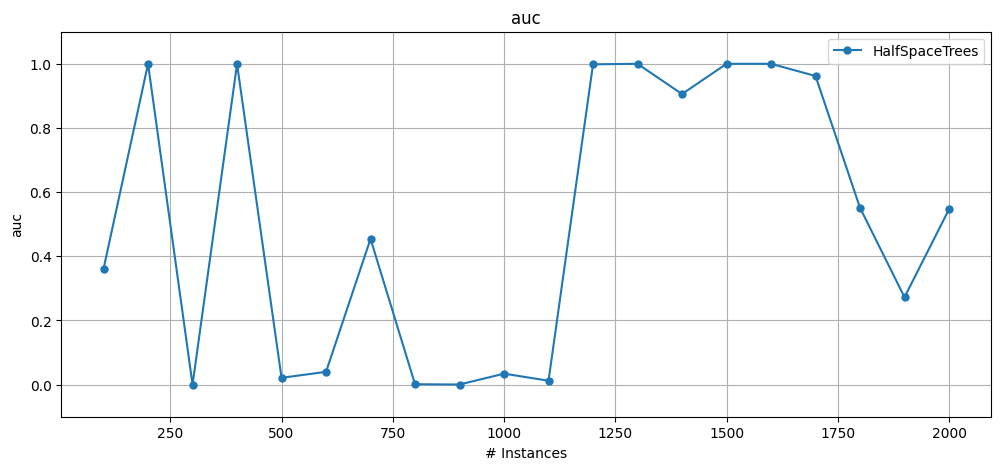

Autoencoder AUC: 0.423365484313332


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,100.0,0.736631,0.021084,0.66,0.0,0.000000,0.515152,0.0,0.0,-0.096774
1,200.0,0.288352,0.004165,0.35,0.0,0.736631,1.857143,0.0,0.0,-0.413043
2,300.0,0.499699,0.008380,0.79,0.0,0.288352,0.265823,0.0,0.0,0.526316
3,400.0,0.123939,0.001208,0.38,0.0,0.499699,1.631579,0.0,0.0,-0.233831
4,500.0,0.653553,0.012236,0.53,0.0,0.123939,0.886792,0.0,0.0,0.116541
5,600.0,0.193548,0.002075,0.62,0.0,0.653553,0.612903,0.0,0.0,0.242525
6,700.0,0.186633,0.002319,0.39,0.0,0.193548,1.564103,0.0,0.0,-0.213068
7,800.0,0.502652,0.008293,0.43,0.0,0.186633,1.325581,0.0,0.0,-0.154430
8,900.0,0.368081,0.006007,0.45,0.0,0.502652,1.222222,0.0,0.0,-0.109865
9,1000.0,0.287440,0.003519,0.46,0.0,0.368081,1.173913,0.0,0.0,-0.077844


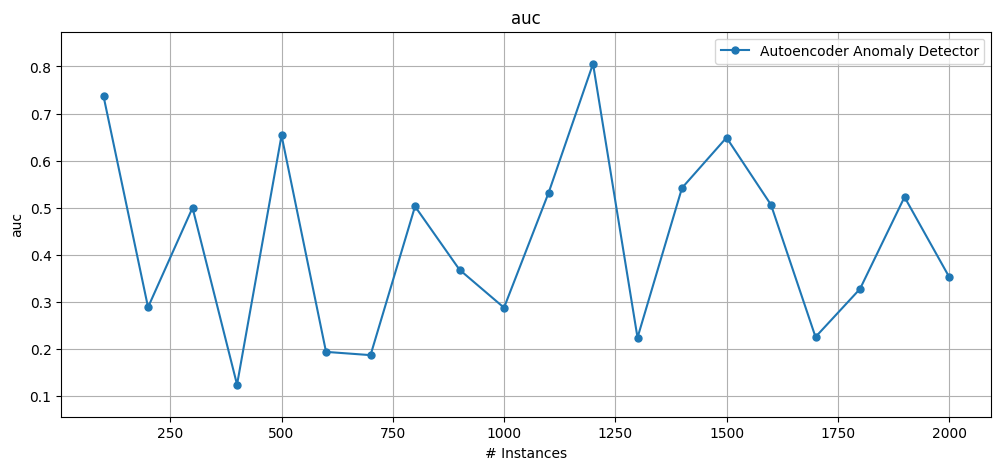

OnlineIsolationForest AUC: 0.5189425296006421


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,100.0,0.416667,0.155893,0.37,-0.136364,0.000000,0.515152,0.390393,0.558824,-1.032258
1,200.0,0.568791,0.020393,0.65,0.000000,0.416667,1.857143,0.000000,1.000000,0.239130
2,300.0,0.587101,0.006772,0.21,0.000000,0.568791,0.265823,0.000000,1.000000,-0.781955
3,400.0,0.700764,0.006075,0.62,0.000000,0.587101,1.631579,0.000000,1.000000,0.243781
4,500.0,0.458450,0.002215,0.47,0.000000,0.700764,0.886792,0.000000,1.000000,0.003759
5,600.0,0.300509,0.001740,0.38,0.000000,0.458450,0.612903,0.000000,1.000000,-0.235880
6,700.0,0.461538,0.001429,0.61,0.000000,0.300509,1.564103,0.000000,1.000000,0.224432
7,800.0,0.643819,0.001934,0.57,0.000000,0.461538,1.325581,0.000000,1.000000,0.129114
8,900.0,0.354747,0.000667,0.55,0.000000,0.643819,1.222222,0.000000,1.000000,0.091928
9,1000.0,0.210950,0.000281,0.54,0.000000,0.354747,1.173913,0.000000,1.000000,0.081836


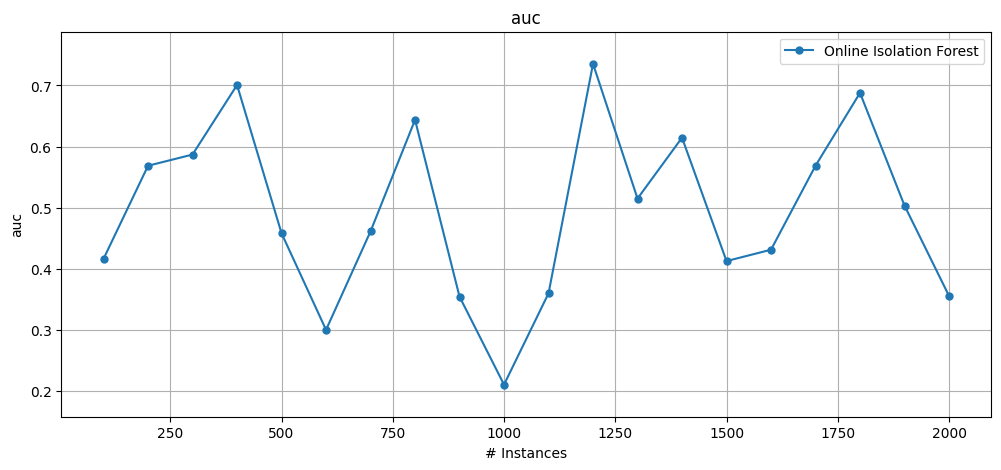

StreamRHF AUC: 0.6979312997524918


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,100.0,0.706996,0.108133,0.33,-0.020097,0.000000,0.515152,0.000000,0.970588,-1.161290
1,200.0,0.556703,0.059716,0.65,0.000000,0.706996,1.857143,0.000000,1.000000,0.239130
2,300.0,0.823990,0.140822,0.22,0.005356,0.556703,0.265823,0.112509,1.000000,-0.759398
3,400.0,0.508489,0.054962,0.62,0.000000,0.823990,1.631579,0.000000,1.000000,0.243781
4,500.0,0.688880,0.107760,0.48,0.017756,0.508489,0.886792,0.137361,1.000000,0.022556
5,600.0,0.528862,0.067283,0.38,0.000000,0.688880,0.612903,0.000000,1.000000,-0.235880
6,700.0,0.408785,0.038696,0.60,-0.019888,0.528862,1.564103,0.000000,0.983607,0.204545
7,800.0,0.289678,0.024288,0.56,-0.019935,0.408785,1.325581,0.000000,0.982456,0.108861
8,900.0,0.566667,0.059632,0.55,0.000000,0.289678,1.222222,0.000000,1.000000,0.091928
9,1000.0,0.765298,0.123063,0.54,0.000000,0.566667,1.173913,0.000000,1.000000,0.081836


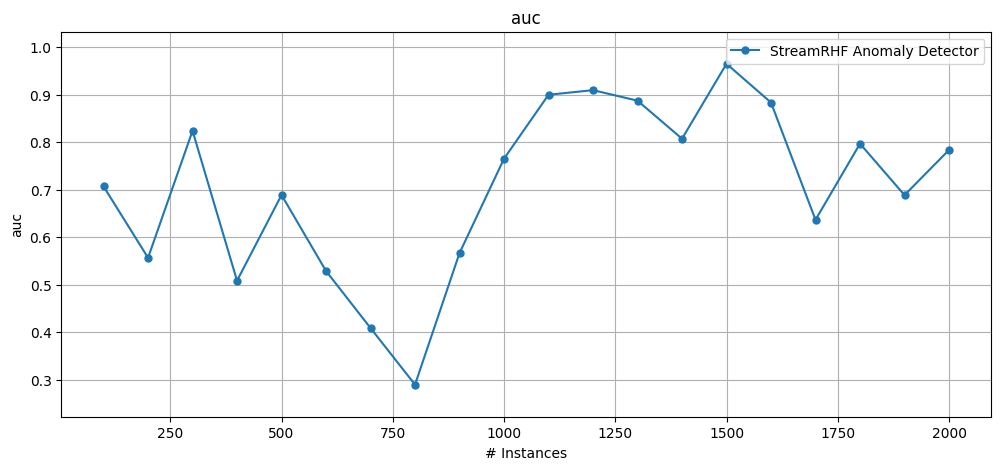

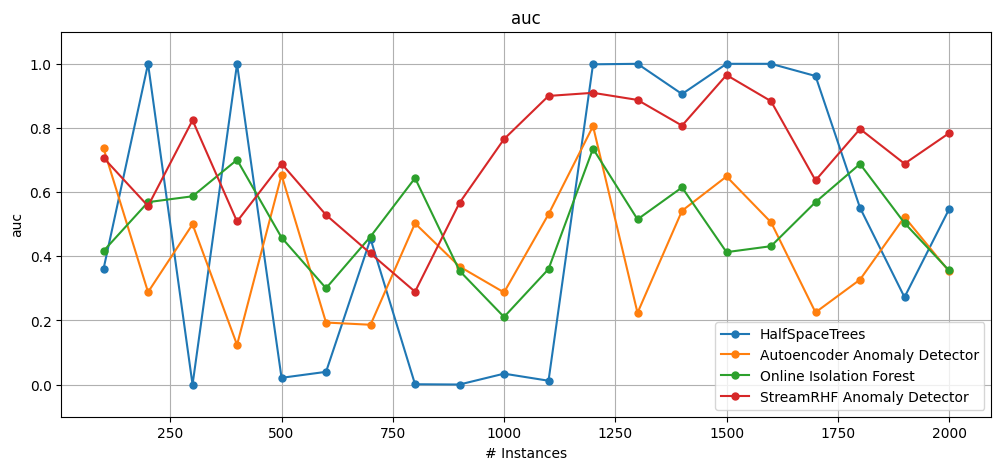

In [12]:
from capymoa.datasets import ElectricityTiny
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.anomaly import HalfSpaceTrees, Autoencoder, OnlineIsolationForest, StreamRHF
from capymoa.evaluation import prequential_evaluation_anomaly

# Load the ElectricityTiny dataset stream
stream = ElectricityTiny()
schema = stream.get_schema()

# Initialize models
hst = HalfSpaceTrees(schema=schema)
ae = Autoencoder(schema=schema, hidden_layer=1)
oif = OnlineIsolationForest(schema=schema, num_trees=10)
streamrhf = StreamRHF(schema=schema, num_trees=10)

# Run prequential evaluation for each model
results_hst = prequential_evaluation_anomaly(stream=stream, learner=hst, window_size=100)
print(f"HalfSpaceTrees AUC: {results_hst.auc()}")
display(results_hst.windowed.metrics_per_window())
plot_windowed_results(results_hst, metric="auc", save_only=False)

results_ae = prequential_evaluation_anomaly(stream=stream, learner=ae, window_size=100)
print(f"Autoencoder AUC: {results_ae.auc()}")
display(results_ae.windowed.metrics_per_window())
plot_windowed_results(results_ae, metric="auc", save_only=False)

results_oif = prequential_evaluation_anomaly(stream=stream, learner=oif, window_size=100)
print(f"OnlineIsolationForest AUC: {results_oif.auc()}")
display(results_oif.windowed.metrics_per_window())
plot_windowed_results(results_oif, metric="auc", save_only=False)

results_streamrhf = prequential_evaluation_anomaly(stream=stream, learner=streamrhf, window_size=100)
print(f"StreamRHF AUC: {results_streamrhf.auc()}")
display(results_streamrhf.windowed.metrics_per_window())
plot_windowed_results(results_streamrhf, metric="auc", save_only=False)

# Plot final comparison of all models
plot_windowed_results(
    results_hst, results_ae, results_oif, results_streamrhf, metric="auc", save_only=False
)


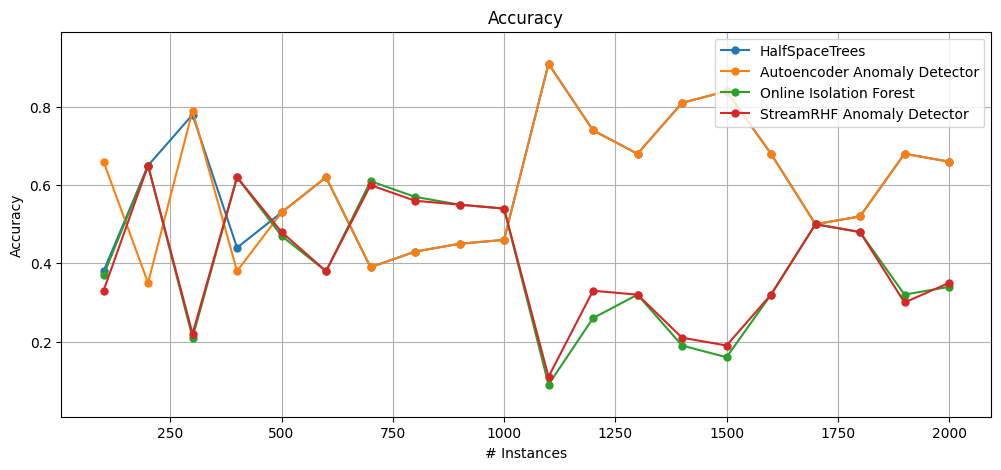

In [15]:
# Plot final comparison of all models
plot_windowed_results(
    results_hst, results_ae, results_oif, results_streamrhf, metric="Accuracy", save_only=False
)

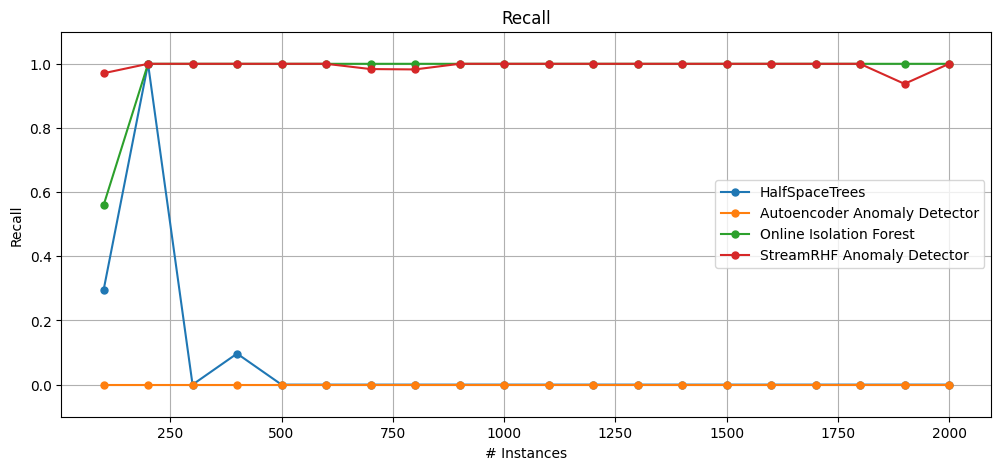

In [16]:
# Plot final comparison of all models
plot_windowed_results(
    results_hst, results_ae, results_oif, results_streamrhf, metric="Recall", save_only=False
)

### Comparison with the AP score

Since AP score was used in the paper, even though the metric is not in CapyMOA we decided that it would be a good comparison to do

our StreamRHF initialized
20
Evaluating HalfSpaceTrees...
Evaluating Autoencoder...
Evaluating OnlineIsolationForest...
Evaluating StreamRHF...


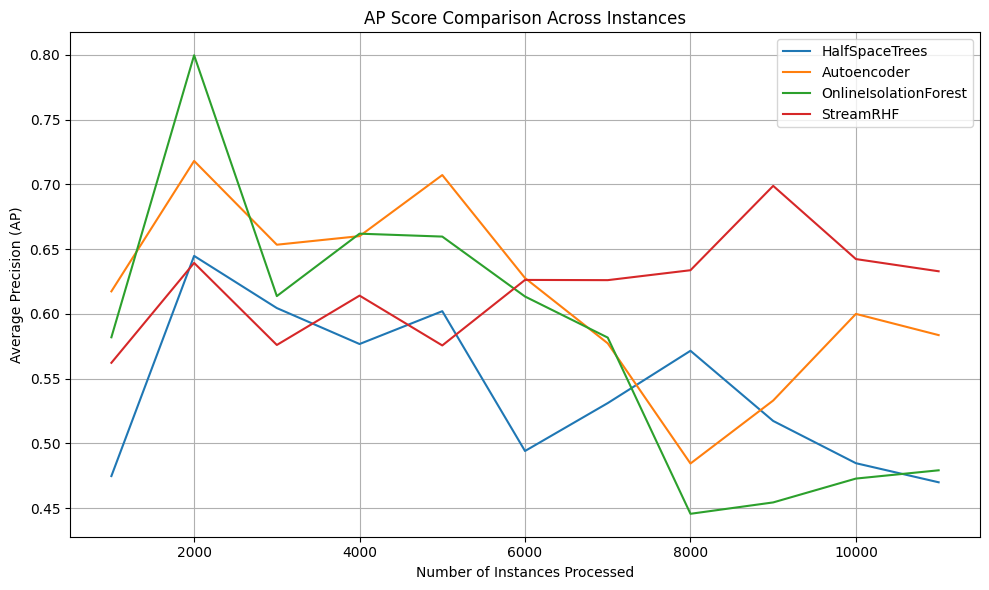

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from capymoa.datasets import Electricity
from capymoa.anomaly import HalfSpaceTrees, Autoencoder, OnlineIsolationForest, StreamRHF

# Initialize dataset stream
stream = Electricity()
schema = stream.get_schema()

# Limit the number of instances to 11,000
max_instances = 11000
window_size = 1000  # Sliding window size

# Initialize models
models = {
    "HalfSpaceTrees": HalfSpaceTrees(schema=schema),
    "Autoencoder": Autoencoder(schema=schema, hidden_layer=1),
    "OnlineIsolationForest": OnlineIsolationForest(schema=schema, num_trees=10),
    "StreamRHF": StreamRHF(schema=schema, num_trees=10),
}

# Initialize results
ap_scores_per_model = {}

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    
    # Restart the stream for each model
    stream.restart()
    anomaly_scores = []
    true_labels = []
    window_ap_scores = []
    instance_count = 0
    processed_instances = 0

    # Process instances in the stream
    while processed_instances < max_instances and stream.has_more_instances():
        instance = stream.next_instance()
        true_labels.append(instance.y_index)
        anomaly_score = 1 - model.score_instance(instance)  # Flip score for consistency
        anomaly_scores.append(anomaly_score)
        model.train(instance)
        instance_count += 1
        processed_instances += 1

        # Compute AP score every 1000 instances using the last 1000
        if instance_count == window_size:
            window_labels = np.array(true_labels[-window_size:])
            window_scores = np.array(anomaly_scores[-window_size:])
            window_ap = average_precision_score(window_labels, window_scores)
            window_ap_scores.append(window_ap)
            instance_count = 0  # Reset window counter

    ap_scores_per_model[model_name] = window_ap_scores

# Plotting AP Scores
plt.figure(figsize=(10, 6))
for model_name, ap_scores in ap_scores_per_model.items():
    # Scale x-axis to reflect the total number of instances
    x_values = np.arange(window_size, len(ap_scores) * window_size + 1, window_size)
    plt.plot(x_values, ap_scores, label=model_name)

plt.title("AP Score Comparison Across Instances")
plt.xlabel("Number of Instances Processed")
plt.ylabel("Average Precision (AP)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
